In [1]:
# ============================================
# FEATURE-SPECIALIZED HYBRID MODEL FOR DIABETES
# SVM + XGBoost + Neural Network
# Each model trained on its best features
# Final output = average of predictions
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE


# ---------------------------
# STEP 1: LOAD DATA
# ---------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes.csv")

# Columns expected:
# ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','Age','Outcome']

# ---------------------------
# STEP 2: DEFINE FEATURE GROUPS FOR EACH MODEL
# ---------------------------
#svm_features = ['Pregnancies', 'BloodPressure', 'SkinThickness']
#xgb_features = ['Glucose', 'Insulin']
#nn_features = ['BMI', 'Age']

# ---------------------------
# STEP 3: TRAIN-TEST SPLIT
# ---------------------------
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# ---------------------------
# STEP 4: SCALE EACH FEATURE GROUP
# ---------------------------
scaler_svm = StandardScaler()
scaler_xgb = StandardScaler()
scaler_nn = StandardScaler()

X_train_svm = scaler_svm.fit_transform(X_train_bal)
X_test_svm = scaler_svm.transform(X_test)

X_train_xgb = scaler_xgb.fit_transform(X_train_bal)
X_test_xgb = scaler_xgb.transform(X_test)

X_train_nn = scaler_nn.fit_transform(X_train_bal)
X_test_nn = scaler_nn.transform(X_test)

# ---------------------------
# STEP 5: DEFINE MODELS
# ---------------------------
svm_model = SVC(probability=True, kernel='rbf', C=1, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          n_estimators=100, learning_rate=0.1, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu',
                         solver='adam', max_iter=300, random_state=42)

# ---------------------------
# STEP 6: TRAIN MODELS ON THEIR FEATURES
# ---------------------------
print("🚀 Training specialized models...")

svm_model.fit(X_train_svm, y_train_bal)
xgb_model.fit(X_train_xgb, y_train_bal)
nn_model.fit(X_train_nn, y_train_bal)

# ---------------------------
# STEP 7: INDIVIDUAL MODEL PREDICTIONS
# ---------------------------
svm_probs = svm_model.predict_proba(X_test_svm)[:,1]
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:,1]
nn_probs = nn_model.predict_proba(X_test_nn)[:,1]

# ---------------------------
# STEP 8: COMBINE PREDICTIONS (AVERAGE VOTING)
# ---------------------------
final_probs = (svm_probs + xgb_probs + nn_probs) / 3
final_pred = (final_probs >= 0.5).astype(int)

# ---------------------------
# STEP 9: EVALUATE PERFORMANCE
# ---------------------------
accuracy = accuracy_score(y_test, final_pred)
print(f"\n✅ Final Hybrid Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, final_pred))

# ---------------------------
# STEP 10: SAVE MODELS & SCALERS
# ---------------------------
joblib.dump(svm_model, 'svm_specialized.pkl')
joblib.dump(xgb_model, 'xgb_specialized.pkl')
joblib.dump(nn_model, 'nn_specialized.pkl')
joblib.dump(scaler_svm, 'scaler_svm.pkl')
joblib.dump(scaler_xgb, 'scaler_xgb.pkl')
joblib.dump(scaler_nn, 'scaler_nn.pkl')
print("\n💾 Models and scalers saved successfully!")

# ---------------------------
# STEP 12: USER INPUT SECTION
# ---------------------------
'''
print("\n💡 Enter your medical details below to predict diabetes:\n")
user_input = {
    'Pregnancies': float(input("Enter number of pregnancies: ")),
    'Glucose': float(input("Enter glucose level: ")),
    'BloodPressure': float(input("Enter blood pressure: ")),
    'SkinThickness': float(input("Enter skin thickness: ")),
    'Insulin': float(input("Enter insulin level: ")),
    'BMI': float(input("Enter BMI: ")),
    'DiabetesPedigreeFunction': float(input("Enter diabetes pedigree function value: ")),
    'Age': float(input("Enter age: "))
}

user_df = pd.DataFrame([user_input])

# ---------------------------
# STEP 13: MAKE FINAL PREDICTION
# ---------------------------

# Scale each group
s_svm = scaler_svm.transform(user_df)
s_xgb = scaler_xgb.transform(user_df)
s_nn = scaler_nn.transform(user_df)

# Predict from each model
p_svm = svm_model.predict_proba(s_svm)[:,1]
p_xgb = xgb_model.predict_proba(s_xgb)[:,1]
p_nn = nn_model.predict_proba(s_nn)[:,1]
'''
# Average
final_probs = (0.2 * svm_probs + 0.5 * xgb_probs + 0.3 * nn_probs)
final_pred = int(final_probs[0] >= 0.5)

print("\n🔍 Final Prediction:", "Diabetic" if final_pred == 1 else "Non-Diabetic")
print(f"🧮 Final Probability: {final_probs[0]:.4f}")

🚀 Training specialized models...

✅ Final Hybrid Accuracy: 74.68%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.74      0.79       100
           1       0.61      0.76      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.75      0.75       154


💾 Models and scalers saved successfully!

🔍 Final Prediction: Diabetic
🧮 Final Probability: 0.9244


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
# ============================================================
# 🤖 HYBRID ENSEMBLE MODEL (SVM + XGBoost + Neural Network)
# Each uses its best feature subset
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# STEP 1: LOAD DATA
# ----------------------------
df = pd.read_csv(r"D:\Manasa College\SE\venv\data\diabetes.csv")  # 8 features + 'Outcome'

features_all = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

X = df[features_all]
y = df['Outcome']

# ----------------------------
# STEP 2: SPLIT DATA
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# ----------------------------
# STEP 3: DEFINE BEST FEATURES FOR EACH MODEL
# ----------------------------
features_svm = ['Glucose', 'BMI', 'Age', 'Insulin', 'BloodPressure']
features_xgb = ['Glucose', 'BMI', 'Age', 'Insulin', 'Pregnancies',
                'DiabetesPedigreeFunction', 'BloodPressure']
features_nn = ['Glucose', 'BMI', 'Age', 'Insulin', 'DiabetesPedigreeFunction']

# ----------------------------
# STEP 4: SCALING (needed for SVM & NN)
# ----------------------------
scaler_svm = StandardScaler()
scaler_nn = StandardScaler()

X_train_svm = scaler_svm.fit_transform(X_train[features_svm])
X_test_svm = scaler_svm.transform(X_test[features_svm])

X_train_nn = scaler_nn.fit_transform(X_train[features_nn])
X_test_nn = scaler_nn.transform(X_test[features_nn])

# XGBoost doesn’t need scaling
X_train_xgb = X_train[features_xgb]
X_test_xgb = X_test[features_xgb]

# ----------------------------
# STEP 5: TRAIN INDIVIDUAL MODELS
# ----------------------------
print("🚀 Training individual models...")

svm_model = SVC(kernel='rbf', probability=True, C=1, random_state=42)
svm_model.fit(X_train_svm, y_train)

xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss',
    n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train)

nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                         max_iter=1000, random_state=42)
nn_model.fit(X_train_nn, y_train)

print("✅ All models trained successfully!\n")

# ----------------------------
# STEP 6: PREDICT PROBABILITIES
# ----------------------------
svm_probs = svm_model.predict_proba(X_test_svm)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
nn_probs = nn_model.predict_proba(X_test_nn)[:, 1]

# ----------------------------
# STEP 7: ENSEMBLE WEIGHTED AVERAGE
# ----------------------------
# You can adjust weights (if you know model accuracy differences)
final_probs = (0.3 * svm_probs) + (0.4 * xgb_probs) + (0.3 * nn_probs)
final_pred = (final_probs >= 0.5).astype(int)

# ----------------------------
# STEP 8: EVALUATE PERFORMANCE
# ----------------------------
accuracy = accuracy_score(y_test, final_pred)
print(f"🎯 Final Ensemble Accuracy: {accuracy*100:.2f}%\n")

print("📄 Classification Report:\n", classification_report(y_test, final_pred))
print("🔍 Confusion Matrix:\n", confusion_matrix(y_test, final_pred))

# ----------------------------
# STEP 9: VISUALIZE CONFUSION MATRIX
# ----------------------------
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, final_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"Hybrid Ensemble Confusion Matrix\nAccuracy = {accuracy*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



=== Fold 1 ===
Top features per model:
SVM: ['Glucose' 'BMI' 'Pregnancies' 'Age' 'DiabetesPedigreeFunction']
XGBoost: ['Glucose' 'BMI' 'Age' 'DiabetesPedigreeFunction' 'SkinThickness']
NN: ['Glucose' 'DiabetesPedigreeFunction' 'BMI' 'SkinThickness' 'Age']


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Fold 1 Ensemble Accuracy: 75.97%

=== Fold 2 ===
Top features per model:
SVM: ['Glucose' 'Age' 'Pregnancies' 'DiabetesPedigreeFunction' 'BMI']
XGBoost: ['Glucose' 'Age' 'BMI' 'Insulin' 'Pregnancies']
NN: ['Glucose' 'Pregnancies' 'Age' 'SkinThickness' 'BMI']


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Fold 2 Ensemble Accuracy: 78.57%

=== Fold 3 ===
Top features per model:
SVM: ['Glucose' 'BMI' 'Age' 'BloodPressure' 'SkinThickness']
XGBoost: ['Glucose' 'BMI' 'Age' 'Insulin' 'BloodPressure']
NN: ['Glucose' 'Age' 'Pregnancies' 'Insulin' 'DiabetesPedigreeFunction']


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Fold 3 Ensemble Accuracy: 75.97%

=== Fold 4 ===
Top features per model:
SVM: ['Glucose' 'Age' 'BMI' 'Pregnancies' 'DiabetesPedigreeFunction']
XGBoost: ['Glucose' 'BMI' 'Age' 'Pregnancies' 'BloodPressure']
NN: ['Glucose' 'Age' 'BMI' 'Pregnancies' 'DiabetesPedigreeFunction']


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Fold 4 Ensemble Accuracy: 73.20%

=== Fold 5 ===
Top features per model:
SVM: ['Glucose' 'BMI' 'Pregnancies' 'BloodPressure' 'DiabetesPedigreeFunction']
XGBoost: ['Glucose' 'Age' 'BMI' 'Insulin' 'BloodPressure']
NN: ['Glucose' 'BMI' 'Pregnancies' 'BloodPressure' 'Age']


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Fold 5 Ensemble Accuracy: 71.90%

=== Cross-Validation Accuracy: 75.12% ± 2.34% ===

Training final models on full dataset with selected features...


d:\Manasa College\SE\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



✅ Final models and scalers saved!


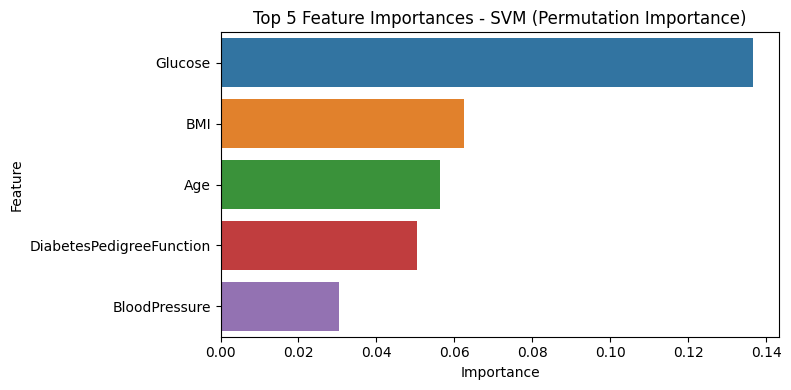

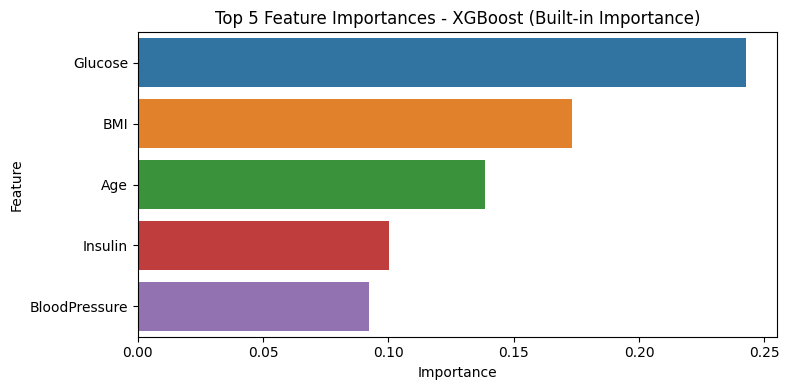

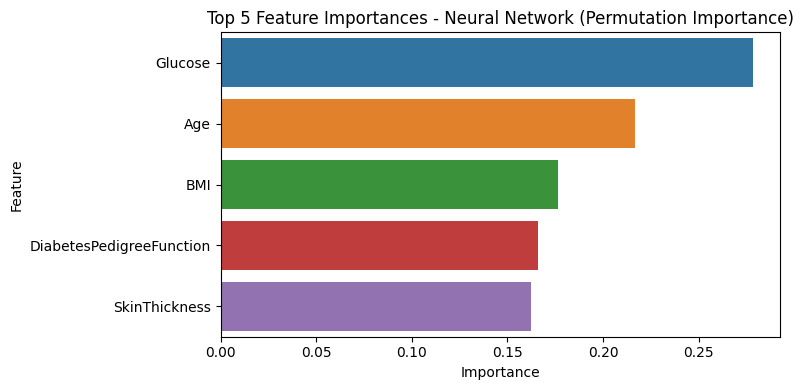


💡 Enter your medical details below to predict diabetes:


User Prediction: Diabetic (Probability: 0.6961)


In [2]:
# ============================================================
# 🔥 ULTIMATE HYBRID DIABETES PREDICTION PIPELINE
# Auto feature selection per model + K-Fold CV + Ensemble
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ----------------------------
# PARAMETERS
# ----------------------------
DATA_PATH = r"D:\Manasa College\SE\venv\data\diabetes.csv"
N_TOP_FEATURES = 5       # Number of top features per model to select
N_SPLITS = 5             # K-Fold splits
ENSEMBLE_WEIGHTS = {'svm': 0.3, 'xgb': 0.4, 'nn': 0.3}  # Ensemble weights

# ----------------------------
# STEP 1: LOAD DATA
# ----------------------------
df = pd.read_csv(DATA_PATH)
features_all = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = df[features_all]
y = df['Outcome']

# ----------------------------
# Helper: Function to get feature importance for each model
# ----------------------------
def get_feature_importance(model, model_name, X_train, y_train, X_val, y_val, features):
    if model_name == 'xgb':
        model.fit(X_train, y_train)
        importance = model.feature_importances_
        imp_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
        return model, imp_df

    elif model_name in ['svm', 'nn']:
        model.fit(X_train, y_train)
        # Permutation importance on validation set
        perm = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42, n_jobs=1)
        imp_df = pd.DataFrame({'Feature': features, 'Importance': perm.importances_mean}).sort_values(by='Importance', ascending=False)
        return model, imp_df

    else:
        raise ValueError("Model name must be 'xgb', 'svm' or 'nn'")

# ----------------------------
# Main Cross-validation routine
# ----------------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
accuracies = []
fold_idx = 1

for train_idx, test_idx in skf.split(X, y):
    print(f"\n=== Fold {fold_idx} ===")
    X_train_full, X_test_full = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Balance training set with SMOTE
    sm = SMOTE(random_state=42)
    X_train_bal, y_train_bal = sm.fit_resample(X_train_full, y_train)

    # ----------------------------
    # Scale full features for initial training & importance calc
    # (XGBoost doesn’t need scaling but for permutation importance and NN/SVM it’s safer)
    # ----------------------------
    scaler_full = StandardScaler()
    X_train_scaled_full = scaler_full.fit_transform(X_train_bal)
    X_test_scaled_full = scaler_full.transform(X_test_full)

    # ----------------------------
    # Initialize models
    # ----------------------------
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    nn_model = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)

    # ----------------------------
    # Get feature importance on full feature set
    # ----------------------------
    svm_model, svm_imp = get_feature_importance(svm_model, 'svm', X_train_scaled_full, y_train_bal, X_test_scaled_full, y_test, features_all)
    xgb_model, xgb_imp = get_feature_importance(xgb_model, 'xgb', X_train_bal, y_train_bal, X_test_full, y_test, features_all)
    nn_model, nn_imp = get_feature_importance(nn_model, 'nn', X_train_scaled_full, y_train_bal, X_test_scaled_full, y_test, features_all)

    print("Top features per model:")
    print("SVM:", svm_imp.head(N_TOP_FEATURES)['Feature'].values)
    print("XGBoost:", xgb_imp.head(N_TOP_FEATURES)['Feature'].values)
    print("NN:", nn_imp.head(N_TOP_FEATURES)['Feature'].values)

    # ----------------------------
    # Select top N features per model
    # ----------------------------
    svm_features = svm_imp.head(N_TOP_FEATURES)['Feature'].tolist()
    xgb_features = xgb_imp.head(N_TOP_FEATURES)['Feature'].tolist()
    nn_features = nn_imp.head(N_TOP_FEATURES)['Feature'].tolist()

    # ----------------------------
    # Scale features per model (fit scaler on train only)
    # ----------------------------
    scaler_svm = StandardScaler()
    X_train_svm = scaler_svm.fit_transform(X_train_bal[svm_features])
    X_test_svm = scaler_svm.transform(X_test_full[svm_features])

    # XGBoost typically no scaling needed, but for permutation importance, earlier was scaled; here keep raw:
    X_train_xgb = X_train_bal[xgb_features]
    X_test_xgb = X_test_full[xgb_features]

    scaler_nn = StandardScaler()
    X_train_nn = scaler_nn.fit_transform(X_train_bal[nn_features])
    X_test_nn = scaler_nn.transform(X_test_full[nn_features])

    # ----------------------------
    # Retrain models on selected features
    # ----------------------------
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train_svm, y_train_bal)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train_xgb, y_train_bal)

    nn_model = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)
    nn_model.fit(X_train_nn, y_train_bal)

    # ----------------------------
    # Predict probabilities
    # ----------------------------
    svm_probs = svm_model.predict_proba(X_test_svm)[:, 1]
    xgb_probs = xgb_model.predict_proba(X_test_xgb)[:, 1]
    nn_probs = nn_model.predict_proba(X_test_nn)[:, 1]

    # ----------------------------
    # Ensemble weighted average
    # ----------------------------
    final_probs = (ENSEMBLE_WEIGHTS['svm'] * svm_probs +
                   ENSEMBLE_WEIGHTS['xgb'] * xgb_probs +
                   ENSEMBLE_WEIGHTS['nn'] * nn_probs)
    final_pred = (final_probs >= 0.5).astype(int)

    acc = accuracy_score(y_test, final_pred)
    print(f"Fold {fold_idx} Ensemble Accuracy: {acc*100:.2f}%")

    accuracies.append(acc)
    fold_idx += 1

# ----------------------------
# Summary of CV results
# ----------------------------
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
print(f"\n=== Cross-Validation Accuracy: {mean_acc*100:.2f}% ± {std_acc*100:.2f}% ===")

# ----------------------------
# Retrain final models on FULL dataset with selected features
# ----------------------------
print("\nTraining final models on full dataset with selected features...")

# Balance full data
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X, y)

# Feature importance on full balanced data
scaler_full_final = StandardScaler()
X_bal_scaled = scaler_full_final.fit_transform(X_bal)

# Train all models on full features for importance
svm_model, svm_imp = get_feature_importance(SVC(kernel='rbf', probability=True, random_state=42), 
                                            'svm', X_bal_scaled, y_bal, X_bal_scaled, y_bal, features_all)
xgb_model, xgb_imp = get_feature_importance(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                                           'xgb', X_bal, y_bal, X_bal, y_bal, features_all)
nn_model, nn_imp = get_feature_importance(MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42),
                                         'nn', X_bal_scaled, y_bal, X_bal_scaled, y_bal, features_all)

# Select top features again
svm_features = svm_imp.head(N_TOP_FEATURES)['Feature'].tolist()
xgb_features = xgb_imp.head(N_TOP_FEATURES)['Feature'].tolist()
nn_features = nn_imp.head(N_TOP_FEATURES)['Feature'].tolist()

# Scale per model
scaler_svm = StandardScaler()
X_bal_svm = scaler_svm.fit_transform(X_bal[svm_features])

scaler_nn = StandardScaler()
X_bal_nn = scaler_nn.fit_transform(X_bal[nn_features])

X_bal_xgb = X_bal[xgb_features]

# Retrain final models
final_svm = SVC(kernel='rbf', probability=True, random_state=42)
final_svm.fit(X_bal_svm, y_bal)

final_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
final_xgb.fit(X_bal_xgb, y_bal)

final_nn = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)
final_nn.fit(X_bal_nn, y_bal)

# Save models and scalers
joblib.dump(final_svm, 'final_svm_model.pkl')
joblib.dump(scaler_svm, 'final_svm_scaler.pkl')

joblib.dump(final_xgb, 'final_xgb_model.pkl')

joblib.dump(final_nn, 'final_nn_model.pkl')
joblib.dump(scaler_nn, 'final_nn_scaler.pkl')

print("\n✅ Final models and scalers saved!")

# ----------------------------
# Visualization of feature importances for each model
# ----------------------------
def plot_feature_importance(df_imp, model_name):
    plt.figure(figsize=(8,4))
    sns.barplot(x='Importance', y='Feature', data=df_imp.head(N_TOP_FEATURES))
    plt.title(f"Top {N_TOP_FEATURES} Feature Importances - {model_name}")
    plt.tight_layout()
    plt.show()

plot_feature_importance(svm_imp, "SVM (Permutation Importance)")
plot_feature_importance(xgb_imp, "XGBoost (Built-in Importance)")
plot_feature_importance(nn_imp, "Neural Network (Permutation Importance)")

# ----------------------------
# Optional: Predict function for new user input
# ----------------------------
print("\n💡 Enter your medical details below to predict diabetes:\n")
input_dict = {
        'Pregnancies': float(input("Enter number of pregnancies: ")),
        'Glucose': float(input("Enter glucose level: ")),
        'BloodPressure': float(input("Enter blood pressure: ")),
        'SkinThickness': float(input("Enter skin thickness: ")),
        'Insulin': float(input("Enter insulin level: ")),
        'BMI': float(input("Enter BMI: ")),
        'DiabetesPedigreeFunction': float(input("Enter diabetes pedigree function value: ")),
        'Age': float(input("Enter age: "))
    }
    
user_df = pd.DataFrame([input_dict])
    
    # Scale features per model
user_svm = scaler_svm.transform(user_df[svm_features])
user_xgb = user_df[xgb_features]  # no scaling for xgb
user_nn = scaler_nn.transform(user_df[nn_features])
    
    # Predict probabilities
p_svm = final_svm.predict_proba(user_svm)[:,1]
p_xgb = final_xgb.predict_proba(user_xgb)[:,1]
p_nn = final_nn.predict_proba(user_nn)[:,1]
    
final_prob = (ENSEMBLE_WEIGHTS['svm'] * p_svm +
                  ENSEMBLE_WEIGHTS['xgb'] * p_xgb +
                  ENSEMBLE_WEIGHTS['nn'] * p_nn)
pred = (final_prob >= 0.5).astype(int)
    
print(f"\nUser Prediction: {'Diabetic' if pred[0] else 'Non-Diabetic'} (Probability: {final_prob[0]:.4f})")

    # Average
final_probs = (0.3 * svm_probs + 0.4 * xgb_probs + 0.3 * nn_probs)
final_pred = int(final_probs[0] >= 0.5)

# ----------------------------
# End of pipeline
# ----------------------------
